In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 11 10:48:58 2023

@author: bas, much copied from postprocessing tutorial
"""

# Importing relevant modules

# %matplotlib inline

# from __future__ import division

import sys
import os
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import math

from collections import OrderedDict

import xpsi

from xpsi import PostProcessing

# choose a seed for the notebook if you want caching to be useful
# and the notebook exactly reproducible
PostProcessing.set_random_seed(42)

from xpsi.global_imports import gravradius


sys.path.append("../")
sys.path.append("../../")
from helper_functions import get_keV_from_log10_Kelvin
from analysis import analysis
ST_marginalise = analysis('local','test', 'marginalise',scenario='kajava')
# We will use the same bounds used during sampling

# Settings names, bounds and labels

ST_marginalise.names=['mass','radius','distance','cos_inclination','p__phase_shift','p__super_colatitude','p__super_radius','p__super_tbb','p__super_te','p__super_tau','elsewhere_temperature', 'column_density']

ST_marginalise.bounds = {'mass':(1.0,3.0),
             'radius':(3.0 * gravradius(1.0), 16.0),
             'distance':(2.0, 5.0),
             'cos_inclination':(0.,1.),
             'p__phase_shift':(-0.25, 0.75),
             'p__super_colatitude':(0.001, math.pi - 0.001),
             'p__super_radius':(0.001, math.pi/2.0 - 0.001),
             'p__super_tbb':(0.001, 0.003),
             'p__super_te': (40., 200.),
             'p__super_tau': (0.5, 3.5),
             'elsewhere_temperature': (5., 7.), #(6.5, 7.),
             'column_density': (0., 3.)}


# Now the labels
ST_marginalise.labels = {'mass': r"M\;\mathrm{[M}_{\odot}\mathrm{]}",
              'radius': r"R_{\mathrm{eq}}\;\mathrm{[km]}",
              'distance': r"D \;\mathrm{[kpc]}",
              'cos_inclination': r"\cos(i)",
              'p__phase_shift': r"\phi_{p}\;\mathrm{[cycles]}",
              'p__super_colatitude': r"\Theta_{spot}\;\mathrm{[rad]}",
              'p__super_radius': r"\zeta_{spot}\;\mathrm{[rad]}",
              'p__super_tbb': r"t_{bb}\;\mathrm{[data units]}",
              'p__super_te': r"t_e data units",
              'p__super_tau': "tau unitless",
              'elsewhere_temperature': r"T_e log10 of Kelvin",
              'column_density': r"n_H 10\^21 cm\^{-2}"}

# ST_marginalise.truths={'mass': 1.4,                               # Mass in solar Mass
#           'radius': 12.,                              # Equatorial radius in km
#           'distance': 3.5,                            # Distance in kpc
#           'cos_inclination': math.cos(math.pi*60/180),          # Cosine of Earth inclination to rotation axis
#           'p__phase_shift': 0.0,                    # Phase shift
#           'p__super_colatitude': 45*math.pi/180,                # Colatitude of the centre of the superseding region
#           'p__super_radius': 15.5*math.pi/180,                 # Angular radius of the (circular) superseding region
#           'p__super_tbb': 0.0012,                      # Blackbody temperature
#           'p__super_te': 100.,                          # Electron temperature
#           'p__super_tau': 1.,
#           'elsewhere_temperature': 6.67,
#           'column_density': 1.17}

# kajava scenario
ST_marginalise.truths={'mass': 1.4,                               # Mass in solar Mass
          'radius': 11.,                              # Equatorial radius in km
          'distance': 3.5,                            # Distance in kpc
          'cos_inclination': math.cos(math.pi*58/180),          # Cosine of Earth inclination to rotation axis
          'p__phase_shift': 0.2,                    # Phase shift
          'p__super_colatitude': 11*math.pi/180,                # Colatitude of the centre of the superseding region
          'p__super_radius': 10*math.pi/180,                 # Angular radius of the (circular) superseding region
          'p__super_tbb': 0.85/511,                      # Blackbody temperature
          'p__super_te': 50*1000/511.,                          # Electron temperature
          'p__super_tau': 1.,
          'elsewhere_temperature': 6.763597262585826,
          'column_density': 1.13}

#### add parameters

ST_marginalise.names +=['compactness']
ST_marginalise.bounds['compactness']=(0.0, 10.)#(gravradius(1.0)/16.0, 1.0/3.0)
ST_marginalise.labels['compactness']= r"M/R_{\mathrm{eq}}"
ST_marginalise.truths['compactness']=gravradius(ST_marginalise.truths['mass'])/ST_marginalise.truths['radius']

ST_marginalise.names +=['T_else_keV']
ST_marginalise.bounds['T_else_keV']=(None, None)#(gravradius(1.0)/16.0, 1.0/3.0)
ST_marginalise.labels['T_else_keV']= r"T_{\mathrm{else}} (keV)"
ST_marginalise.truths['T_else_keV'] = get_keV_from_log10_Kelvin(ST_marginalise.truths['elsewhere_temperature'])

# ST.names +=['T_in_keV']
# ST.bounds['T_in_keV']=(None, None)
# ST.labels['T_in_keV']= r"T_{\mathrm{in}} (keV)"
# ST.truths['T_in_keV'] = get_keV_from_log10_Kelvin(ST.truths['T_in'])

ST_marginalise.names +=['tbb_keV']
ST_marginalise.bounds['tbb_keV']=(None, None)
ST_marginalise.labels['tbb_keV']= r"T_{bb} (keV)"
ST_marginalise.truths['tbb_keV'] = ST_marginalise.truths['p__super_tbb']/511

ST_marginalise.names +=['te_keV']
ST_marginalise.bounds['te_keV']=(None, None)
ST_marginalise.labels['te_keV']= r"T_{e} (keV)"
ST_marginalise.truths['te_keV'] = ST_marginalise.truths['p__super_te']*1000/511


/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1
Rank reporting: 0
scenario is not in environment variables, using passed argument.
scenario: kajava
machine variable is not in environment variables, using passed argument.
machine: local
run_type is not in environment variables, using passed argument.
run_type: test
cannot import analysis name, using test_analysis
analysis_name: test_analysis
num_energies from environment variables failed, proceeding with default.
num_energies: 40
num_leaves from environment variables failed, proceeding with default.
num_leaves: 30
sqrt_num_cells from environment variables failed, proceeding with default.
sq

In [2]:
ST_model = analysis('local', 'test', 'model', scenario='kajava')

ST_model.names=['mass','radius','distance','cos_inclination','p__phase_shift','p__super_colatitude','p__super_radius','p__super_tbb','p__super_te','p__super_tau','elsewhere_temperature', 'T_in', 'R_in', 'column_density']

ST_model.bounds = {'mass':(1.0,3.0),
             'radius':(3.0 * gravradius(1.0), 16.0),
             'distance':(2.0, 5.0),
             'cos_inclination':(0.,1.),
             'p__phase_shift':(-0.25, 0.75),
             'p__super_colatitude':(0.001, math.pi - 0.001),
             'p__super_radius':(0.001, math.pi/2.0 - 0.001),
             'p__super_tbb':(0.001, 0.003),
             'p__super_te': (40., 200.),
             'p__super_tau': (0.5, 3.5),
             'elsewhere_temperature': (5., 7.), #(6.5, 7.),
             'T_in' : (0.01, 0.6), # keV
             'R_in' : (20, 64), # km
             'column_density': (0., 3.)}


# Now the labels
ST_model.labels = {'mass': r"M\;\mathrm{[M}_{\odot}\mathrm{]}",
              'radius': r"R_{\mathrm{eq}}\;\mathrm{[km]}",
              'distance': r"D \;\mathrm{[kpc]}",
              'cos_inclination': r"\cos(i)",
              'p__phase_shift': r"\phi_{p}\;\mathrm{[cycles]}",
              'p__super_colatitude': r"\Theta_{spot}\;\mathrm{[rad]}",
              'p__super_radius': r"\zeta_{spot}\;\mathrm{[rad]}",
              'p__super_tbb': r"t_{bb}\;\mathrm{[data units]}",
              'p__super_te': r"t_e data units",
              'p__super_tau': "tau unitless",
              'elsewhere_temperature': r"T_e log10 of Kelvin",
              'T_in' : r"T_{in} log10 of Kelvin",
              'R_in': r"R_{in} km",
              'column_density': r"n_H 10\^21 cm\^{-2}"}


ST_model.truths={'mass': 1.4,                               # Mass in solar Mass
          'radius': 12.,                              # Equatorial radius in km
          'distance': 3.5,                            # Distance in kpc
          'cos_inclination': math.cos(math.pi*60/180),          # Cosine of Earth inclination to rotation axis
          'p__phase_shift': 0.0,                    # Phase shift
          'p__super_colatitude': 45*math.pi/180,                # Colatitude of the centre of the superseding region
          'p__super_radius': 15.5*math.pi/180,                 # Angular radius of the (circular) superseding region
          'p__super_tbb': 0.0012,                      # Blackbody temperature
          'p__super_te': 100.,                          # Electron temperature
          'p__super_tau': 1.,
          'elsewhere_temperature': 6.67,
          'T_in': 6.4625672669218,
          'R_in': 30.,
          'column_density': 1.17}

ST_model.truths['compactness']=gravradius(ST_model.truths['mass'])/ST_model.truths['radius']

#### SOMETHING SOMETHING COMPACTNESS

ST_model.names +=['compactness']
ST_model.bounds['compactness']=(0.0, 10.)#(gravradius(1.0)/16.0, 1.0/3.0)
ST_model.labels['compactness']= r"M/R_{\mathrm{eq}}"


scenario is not in environment variables, using passed argument.
scenario: kajava
machine variable is not in environment variables, using passed argument.
machine: local
run_type is not in environment variables, using passed argument.
run_type: test
cannot import analysis name, using test_analysis
analysis_name: test_analysis
num_energies from environment variables failed, proceeding with default.
num_energies: 40
num_leaves from environment variables failed, proceeding with default.
num_leaves: 30
sqrt_num_cells from environment variables failed, proceeding with default.
sqrt_num_cells: 50
live_points from environment variables failed, proceeding with default.
live_points: 20
max_iter from environment variables failed, proceeding with default.
max_iter: 10
bkg environment variable is not allowed to be None, using passed argument: model.
bkg: model
support_factor: None
Creating parameter:
    > Named "column_density" with bounds [0.000e+00, 1.000e+01].
    > Units of 10^21 cm^-2.
Creat

In [3]:
getdist_kde_settings = {'ignore_rows': 0,
                        'min_weight_ratio': 1.0e-10,
                        'contours': [0.683, 0.954, 0.997],
                        'credible_interval_threshold': 0.001,
                        'range_ND_contour': 0,
                        'range_confidence': 0.001,
                        'fine_bins': 1024,
                        'smooth_scale_1D': 0.4,
                        'num_bins': 100,
                        'boundary_correction_order': 1,
                        'mult_bias_correction_order': 1,
                        'smooth_scale_2D': 0.4,
                        'max_corr_2D': 0.99,
                        'fine_bins_2D': 512,
                        'num_bins_2D': 40}

In [4]:
base_dir='/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/J1808_synthetic/snellius_runs'

In [5]:
roots = []
job_ids = []
job_labels = []
run_ids = []

# negative background allowed, no support
# job_ids.append('5204648')
# job_labels.append('neg_bkg_lp192')

# fixed background
# job_ids.append('5133792')
# job_labels.append('given_bg_lp192')

# no support
# job_ids.append('4960988')
# job_labels.append('no_poisson_lp192')

# sf = 1.5, seed = 7
# job_ids.append('5210494')
# job_labels.append('sf_15_lp192')

# sf = 1.1, seed = 7
# job_ids.append('4977822')
# job_labels.append('np_sfac_1.1_lp192')
# job_ids.append('5216186')
# job_labels.append('sf_11_se_7_lp192')

# sf = 1.1, seed = 0
# job_ids.append('5210560')
# job_labels.append('sf_11_se_0_lp192')

# sf = 1.1, seed = 1
# job_ids.append('5210597')
# job_labels.append('sf_11_se_1_lp192')

# sf = 1.1, seed = 7, lp = 1000
# job_ids.append('5210748')
# job_labels.append('sf_11_lp1000')

# sf = 1.1, seed = 7, poisson noise
# job_ids.append('5215731')
# job_labels.append('sf_11_pn_lp192')
# run_ids.append('sf_11')

# sf = 1.001
# job_ids.append('5134108')
# job_labels.append('sf_1001_lp192')
# run_ids.append('old')

# sf = 1.001 (2) 
# job_ids.append('5217380')
# job_labels.append('sf_1001_lp192')
# run_ids.append('new')

# sf = 1.001 negative background allowed, 
# job_ids.append('5206416')
# job_labels.append('nb_sf_1001_lp192')

# sf = 1.00005
# job_ids.append('5196881')
# job_labels.append('sf_100005_lp192')

# bkg_derived_lp192  
# job_ids.append('5316365')
# job_labels.append('bkg_derived_lp192')
# run_ids.append('bkg_derived')

# bkg_tight_lp192
# job_ids.append('5325163')
# job_labels.append('bkg_tight_lp192')
# run_ids.append('bkg_tight')

# kajava 
# job_ids.append('5523257')
# job_labels.append('k_sf_none_lp192')
# run_ids.append('sf_none')

job_ids.append('5523560')
job_labels.append('k_sf_5e-1_lp192')
run_ids.append('sf_5e-1')

base_dirs = []
for job_id, job_label, index in zip(job_ids, job_labels, range(len(job_ids))):
    base_dirs.append(f'{base_dir}/{job_label}/{job_id}/{job_label}')
    roots.append('run_ST_')

In [6]:
marginalise_run_ids = run_ids[:]

ST_marginalise.runs = xpsi.Runs.load_runs(ID='ST_marginalise',
                               run_IDs=marginalise_run_ids,
                               roots=roots,
                               base_dirs=base_dirs,
                               use_nestcheck=[False]*len(job_ids),
                               kde_settings=getdist_kde_settings,
                               likelihood=ST_marginalise.likelihood,
                               names=ST_marginalise.names,
                               bounds=ST_marginalise.bounds,
                               labels=ST_marginalise.labels,
                               truths=ST_marginalise.truths,
                               implementation='multinest',
                               overwrite_transformed=True)

In [7]:
roots = []
job_ids = []
job_labels = []
run_ids = []

# bkg_tight_lp192
# job_ids.append('5325163')
# job_labels.append('bkg_tight_lp192')
# run_ids.append('bkg_tight')

# kajava 
job_ids.append('5523517')
job_labels.append('k_bkg_lp192')
run_ids.append('bkg')

base_dirs = []
for job_id, job_label, index in zip(job_ids, job_labels, range(len(job_ids))):
    base_dirs.append(f'{base_dir}/{job_label}/{job_id}/{job_label}')
    roots.append('run_ST_')

In [8]:
model_run_ids = run_ids[:]

ST_model.runs = xpsi.Runs.load_runs(ID='ST_model',
                               run_IDs=model_run_ids,
                               roots=roots,
                               base_dirs=base_dirs,
                               use_nestcheck=[False]*len(job_ids),
                               kde_settings=getdist_kde_settings,
                               likelihood=ST_marginalise.likelihood,
                               names=ST_marginalise.names,
                               bounds=ST_marginalise.bounds,
                               labels=ST_marginalise.labels,
                               truths=ST_marginalise.truths,
                               implementation='multinest',
                               overwrite_transformed=True)

In [9]:
# only_three = ["mass", "radius", "compactness"]

# pp = xpsi.PostProcessing.CornerPlotter([ST_marginalise.runs, ST_model.runs])
# fig = pp.plot(
#      params=only_three,
#      IDs=OrderedDict([('ST_marginalise', marginalise_run_ids),('ST_model', model_run_ids)]),
#      prior_density=False,
#      KL_divergence=True,
#      ndraws=5e4,
#      combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
#      param_plot_lims={},
#      bootstrap_estimators=False,
#      bootstrap_density=False,
#      n_simulate=200,
#      crosshairs=True,
#      write=True,
#      ext='.png',
#      maxdots=3000,
#      root_filename=f'run',
#      credible_interval_1d=True,
#      credible_interval_1d_all_show=True, # To show credible intervals for all runs/models
#      show_vband=[0,1],                   # To list which vertical colored bands are shown in 1D-posteriors
#                                          #  0 for run_seed0,  1 for run_seed42
#      annotate_credible_interval=True,
#      compute_all_intervals=False,
#      sixtyeight=True,
#      axis_tick_x_rotation=45.0,
#      num_plot_contours=3,
#      subplot_size=4.0,
#      legend_corner_coords=(0.675,0.8),
#      legend_frameon=False,
#      scale_attrs=OrderedDict([('legend_fontsize', 2.0),
#                               ('axes_labelsize', 1.35),
#                               ('axes_fontsize', 'axes_labelsize'),
#                              ]
#                             ),
#      colormap='Reds',
#      shaded=True,
#      shade_root_index=-1,
#      rasterized_shade=True,
#      no_ylabel=True,
#      no_ytick=True,
#      lw=1.0,
#      lw_1d=1.0,
#      filled=False,
#      normalize=True,
#      veneer=True,
#      #contour_colors=['orange'],
#      tqdm_kwargs={'disable': False},
#      lengthen=2.0,
#      embolden=1.0,
#      nx=500)



In [10]:
def cornerplot(parameters): 
    pp = xpsi.PostProcessing.CornerPlotter([ST_marginalise.runs, ST_model.runs])
    fig = pp.plot(
         params=parameters,
         IDs=OrderedDict([('ST_marginalise', marginalise_run_ids),('ST_model', model_run_ids)]),
         prior_density=False,
         KL_divergence=True,
         ndraws=5e4,
         combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
         param_plot_lims={},
         bootstrap_estimators=False,
         bootstrap_density=False,
         n_simulate=200,
         crosshairs=True,
         write=True,
         ext='.png',
         maxdots=3000,
         root_filename=f'run',
         credible_interval_1d=True,
         credible_interval_1d_all_show=True, # To show credible intervals for all runs/models
         show_vband=[0,1],                   # To list which vertical colored bands are shown in 1D-posteriors
                                             #  0 for run_seed0,  1 for run_seed42
         annotate_credible_interval=True,
         compute_all_intervals=False,
         sixtyeight=True,
         axis_tick_x_rotation=45.0,
         num_plot_contours=3,
         subplot_size=4.0,
         legend_corner_coords=(0.675,0.8),
         legend_frameon=False,
         scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                                  ('axes_labelsize', 1.35),
                                  ('axes_fontsize', 'axes_labelsize'),
                                 ]
                                ),
         colormap='Reds',
         shaded=True,
         shade_root_index=-1,
         rasterized_shade=True,
         no_ylabel=True,
         no_ytick=True,
         lw=1.0,
         lw_1d=1.0,
         filled=False,
         normalize=True,
         veneer=True,
         #contour_colors=['orange'],
         tqdm_kwargs={'disable': False},
         lengthen=2.0,
         embolden=1.0,
         nx=500)



Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['mass', 'radius']
plotting:  ['mass', 'compactness']
plotting:  ['radius', 'compactness']
Veneering spines and axis ticks...
Veneered.
Adding parameter truth crosshairs...
Added crosshairs.
Adding 1D marginal credible intervals...
Plotting credible regions for posterior ST_marginalise...
Added 1D marginal credible intervals.
Constructed lower-triangle posterior density plot.
Posterior density estimation complete.


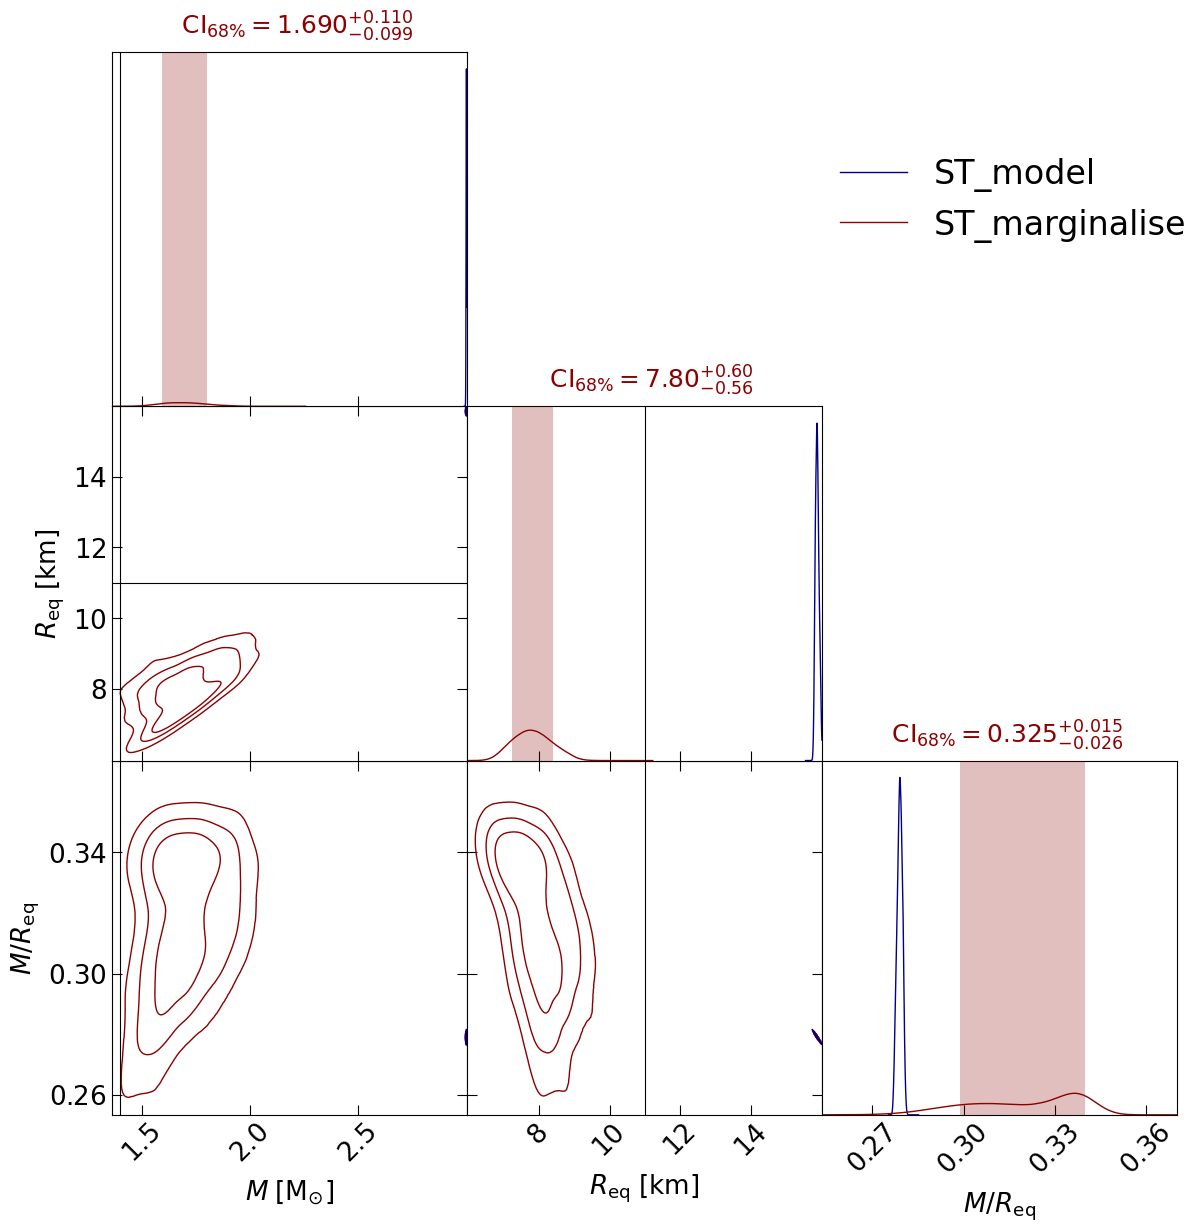

In [11]:
mass_radius = ["mass", "radius", "compactness"]
cornerplot(mass_radius)

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:


MCSamplesError: Parameter range is <= 0: column_density

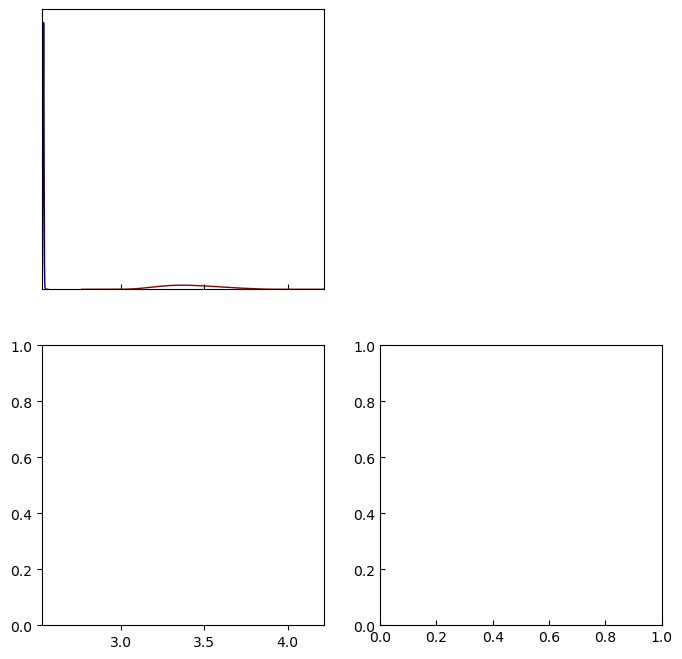

In [12]:
# interstellar = ["distance", "column_density"]
# cornerplot(interstellar)

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['cos_inclination', 'p__phase_shift']
plotting:  ['cos_inclination', 'p__super_colatitude']
plotting:  ['cos_inclination', 'p__super_radius']
plotting:  ['p__phase_shift', 'p__super_colatitude']
plotting:  ['p__phase_shift', 'p__super_radius']
plotting:  ['p__super_colatitude', 'p__super_radius']
Veneering spines and axis ticks...
Veneered.
Adding parameter truth crosshairs...
Added crosshairs.
Adding 1D marginal credible intervals...
Plotting credible regions for posterior ST_marginalise...
Added 1D marginal credible intervals.
Constructed lower-triangle posterior density plot.
Posterior density estimation complete.


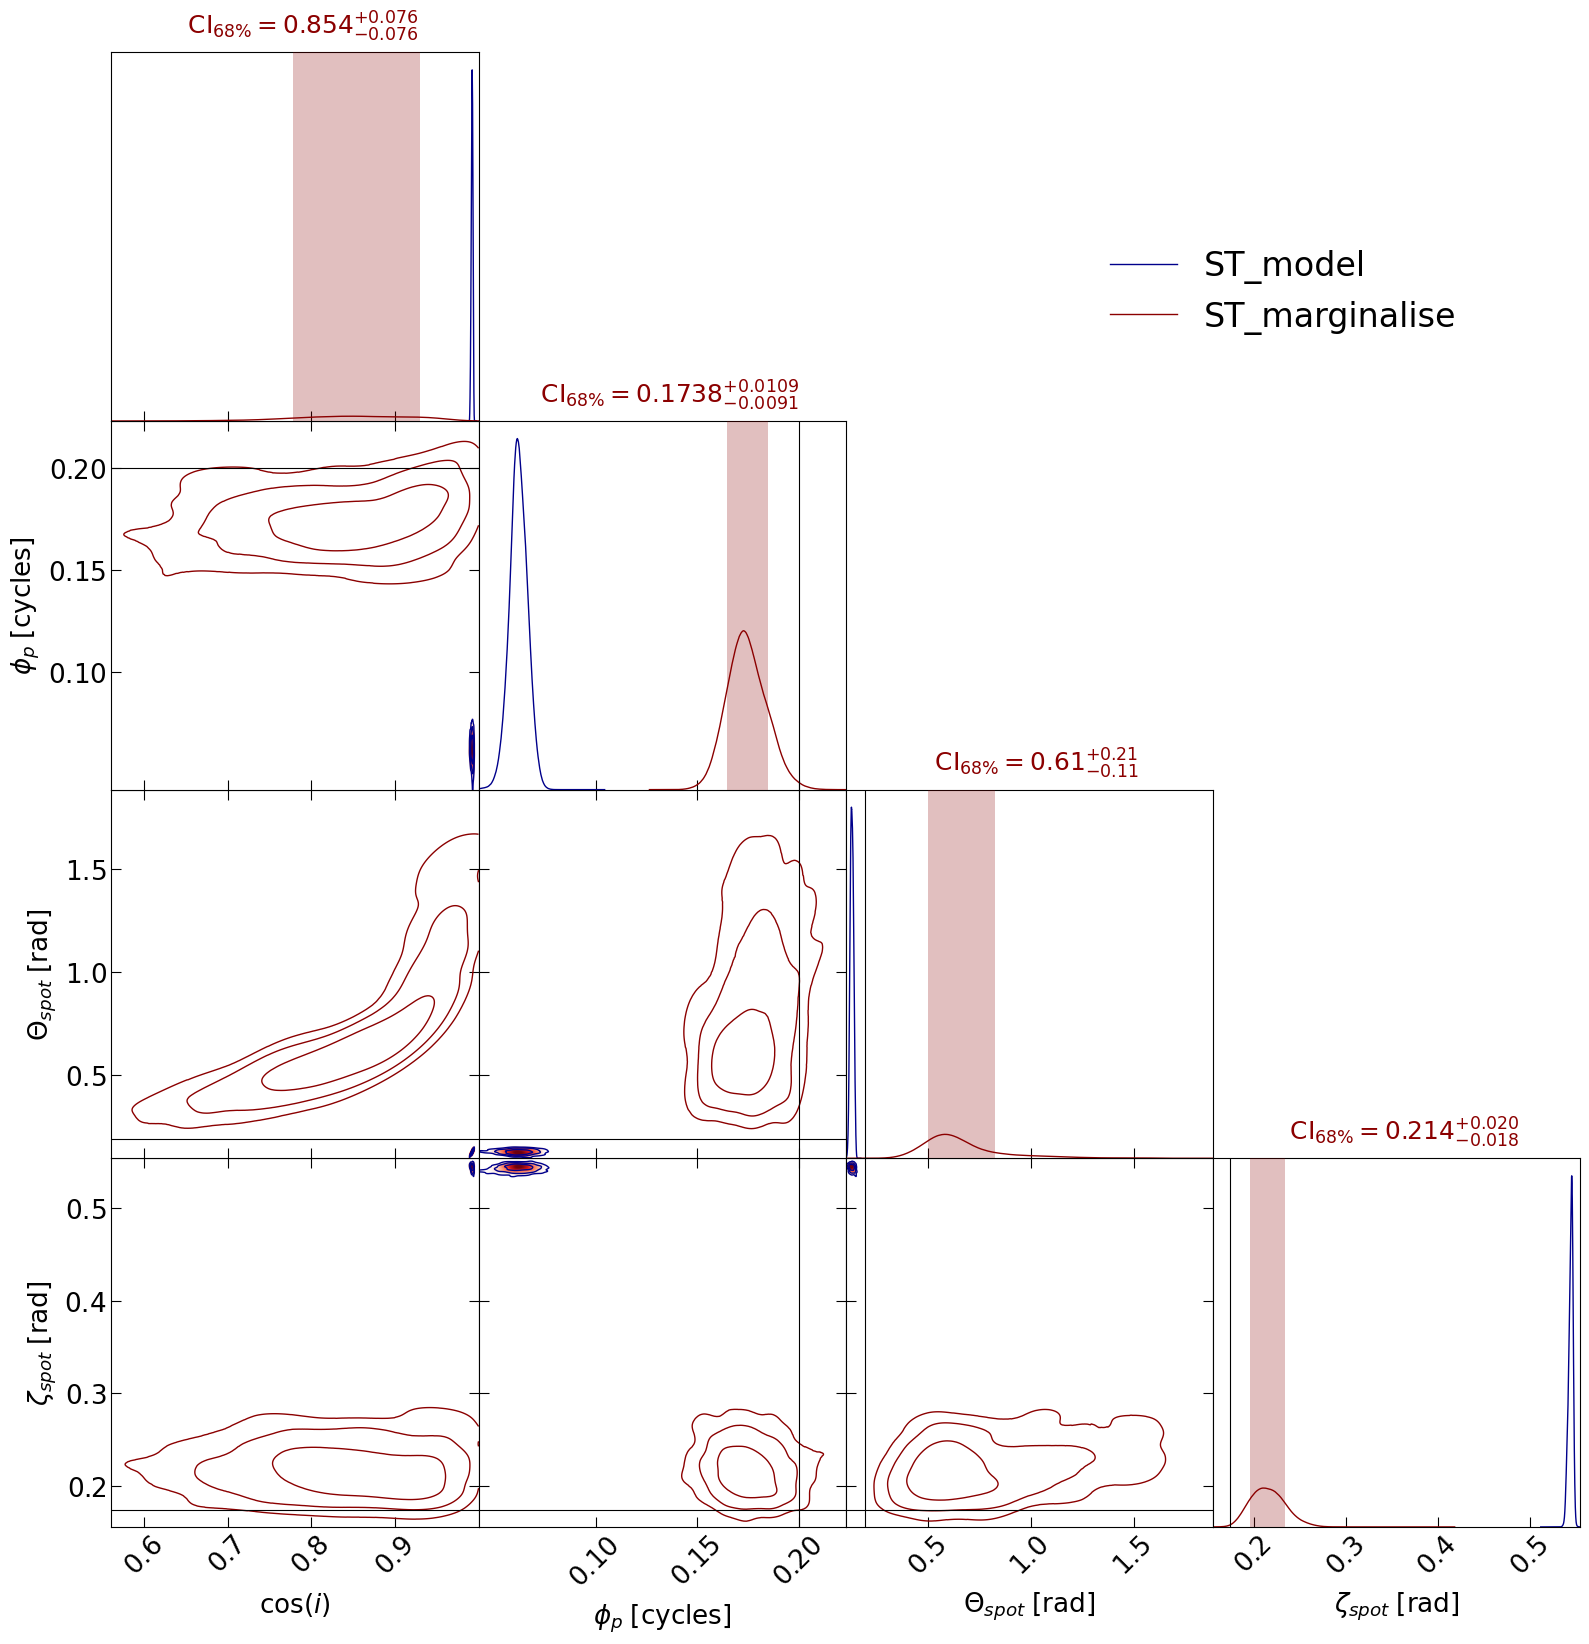

In [13]:
geometry = ['cos_inclination', 'p__phase_shift', 'p__super_colatitude', 'p__super_radius']

cornerplot(geometry)

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['tbb_keV', 'te_keV']
plotting:  ['tbb_keV', 'p__super_tau']
plotting:  ['te_keV', 'p__super_tau']
Veneering spines and axis ticks...
Veneered.
Adding parameter truth crosshairs...
Added crosshairs.
Adding 1D marginal credible intervals...
Plotting credible regions for posterior ST_marginalise...
Added 1D marginal credible intervals.
Constructed lower-triangle posterior density plot.
Posterior density estimation complete.


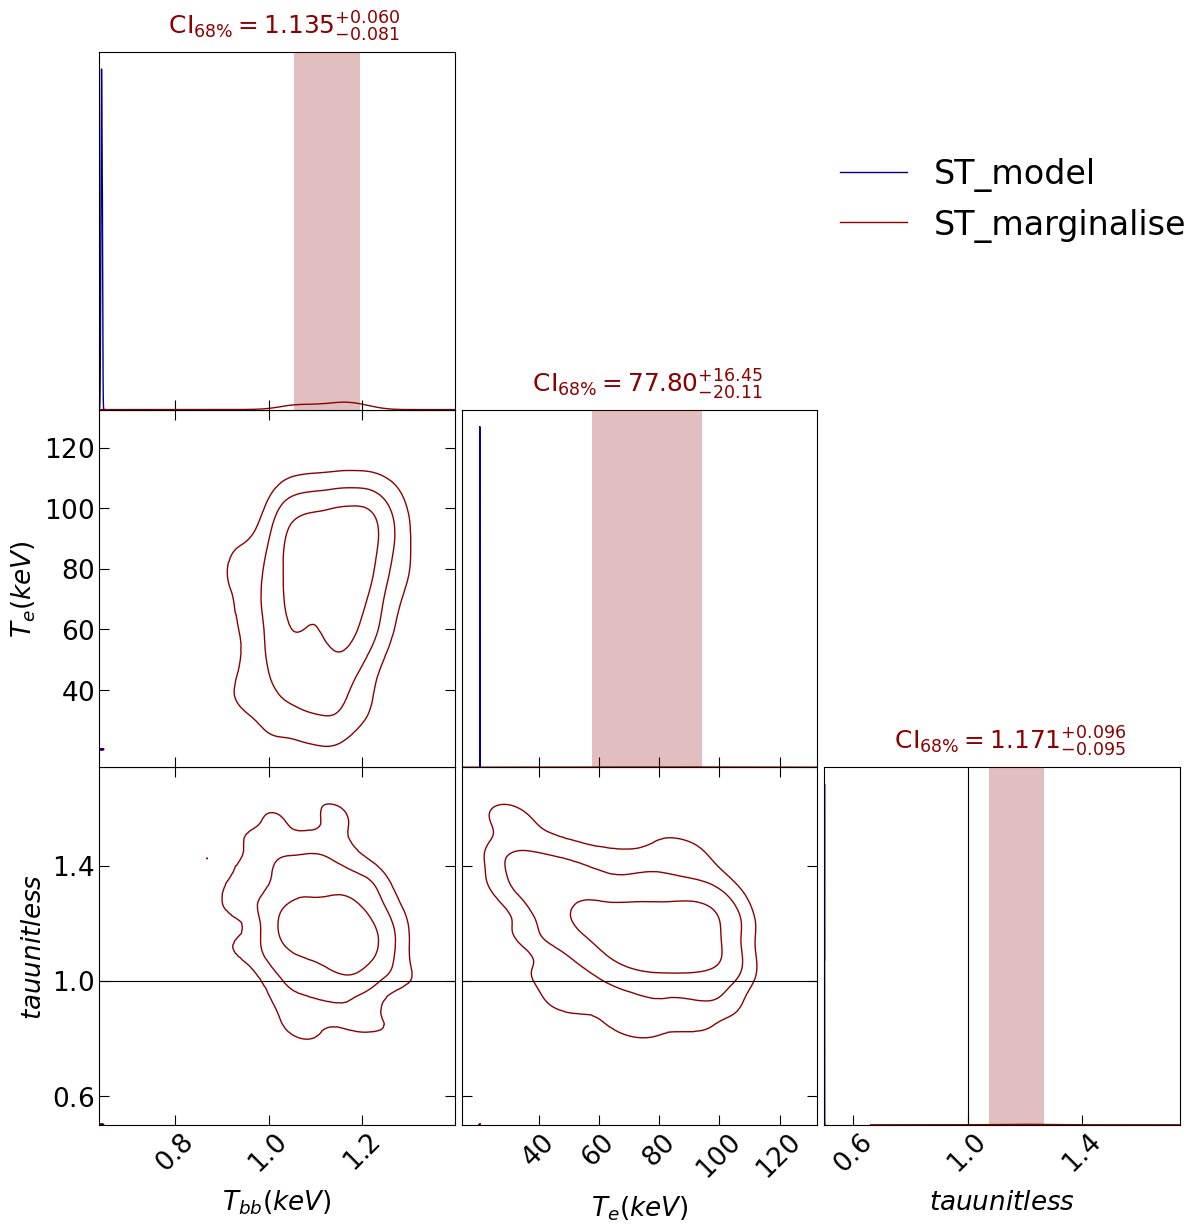

In [14]:
atmosphere = ['tbb_keV', 'te_keV', 'p__super_tau']
cornerplot(atmosphere)

Instantiating a residual plotter for posterior checking...
Residual plotter instantiated.
Plotting signals for posterior checking...
Curating set of runs for posterior plotting...
Run set curated.
Handling posterior ST_model...
Checking whether an existing cache can be read:
Creating new cache file...
Attempting to archive existing cache file in a subdirectory...
Targeting subdirectory: ./archive.
Exisiting cache file archived in subdirectory ./archive.
Initialising cache file...
Cache file initialised.
Cache file created.
Cache state determined.


Signal caching loop:   0%|          | 0/3 [00:00<?, ?it/s]

ResidualPlot object iterating over samples...
ResidualPlot object finished iterating.
ResidualPlot object finalizing...
ResidualPlot object finalized.
Writing plot to disk...
ResidualPlot instance plot will be written to path ./ST_model.bkg__signalplot_residuals.pdf...
Written.
Handled posterior ST_model.
Plotted signals for posterior checking.


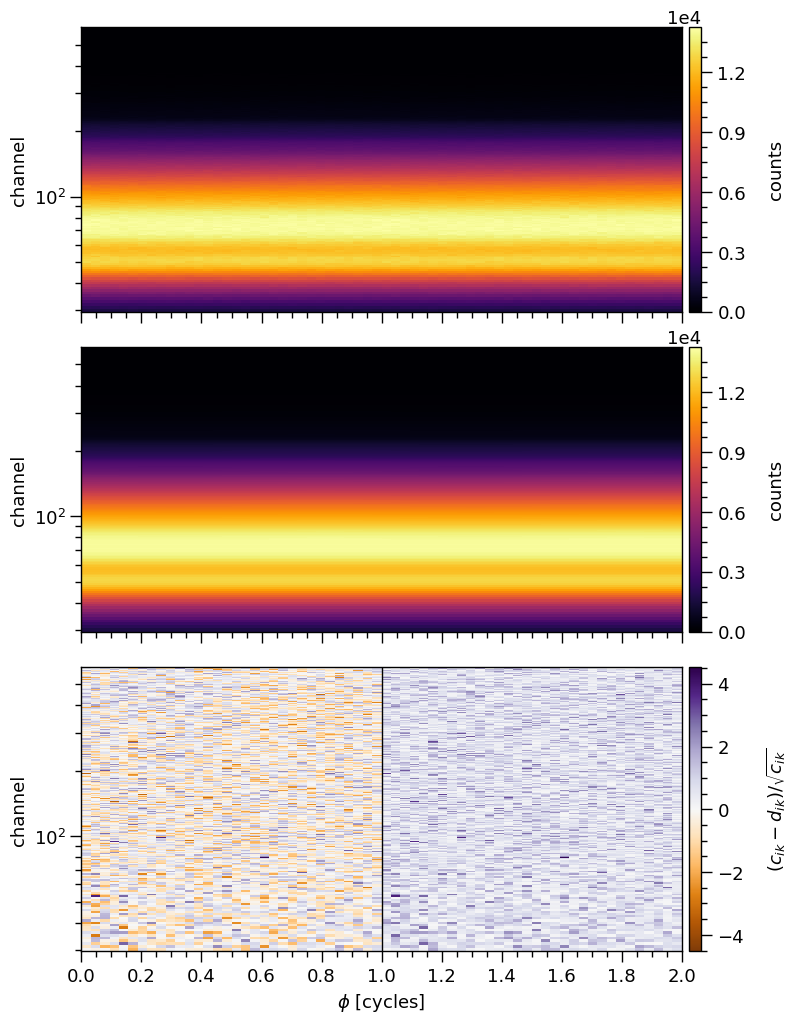

In [18]:
pp = xpsi.SignalPlotter([ST_model.runs])
pp.plot(IDs=OrderedDict([('ST_model', run_ids),
                        ]),
        combine=False, # use these controls if more than one run for a posterior
        combine_all=False,
        force_combine=False,
        only_combined=False,
        force_cache=True,
        nsamples=3,
        plots = {'ST_model': xpsi.ResidualPlot()})

pp.plots["ST_model"].fig


#%%

# plt.savefig(f'./corner_run_se={sampling_efficiency}_lp={live_points}_atm={atmosphere_type}{n_params}_ne={num_energies}_mi={max_iterations}.png')



pp = xpsi.PostProcessing.CornerPlotter([ST.runs])
fig = pp.plot(
     params=["mass", "radius", "compactness"],
     IDs=OrderedDict([('ST', job_labels),]),
     prior_density=False,
     KL_divergence=True,
     ndraws=5e4,
     combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=True,
     write=True,
     ext='.png',
     maxdots=3000,
     root_filename=f'run',
     credible_interval_1d=True,
     credible_interval_1d_all_show=True, # To show credible intervals for all runs/models
     show_vband=[0,1],                   # To list which vertical colored bands are shown in 1D-posteriors
                                         #  0 for run_seed0,  1 for run_seed42
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     axis_tick_x_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('axes_labelsize', 1.35),
                              ('axes_fontsize', 'axes_labelsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     #contour_colors=['orange'],
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500)



In [ ]:
pp = xpsi.PostProcessing.CornerPlotter([ST.runs])
fig = pp.plot(
     params=ST.names,
     IDs=OrderedDict([('ST', run_ids),]),
     prior_density=False,
     KL_divergence=True,
     ndraws=5e4,
     combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=True,
     write=True,
     ext='.png',
     maxdots=3000,
     root_filename=f'run',
     credible_interval_1d=True,
     credible_interval_1d_all_show=True, # To show credible intervals for all runs/models
     show_vband=[0,1],                   # To list which vertical colored bands are shown in 1D-posteriors
                                         #  0 for run_seed0,  1 for run_seed42
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     axis_tick_x_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('axes_labelsize', 1.35),
                              ('axes_fontsize', 'axes_labelsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     #contour_colors=['orange'],
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500)